In [ ]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.formula.api import ols

from statsmodels.stats.proportion import proportion_confint
from scipy.stats import ttest_ind

from joblib import Parallel, delayed

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

---

### Задача 1.
Для ratio-метрик мы хотим подобрать критерий, удовлетворяющий следующим свойствам:
1. Корректность &mdash; контролирование вероятности ошибки 1 рода;
2. Сонаправленность метрики критерия с исходной ratio-метрикой;
3. Возможность применения CUPED для повышения чувствительности.

Будем рассматривать 1000 пользователей.

**1.** Проверим визуально, насколько выполняется сонаправленность для метода бакетов в зависимости от количества бакетов. Рассмотрим случаи 10, 20, 30, 50 бакетов, и, может быть, несколько других.

## Функции с семинарского ноутбука:

In [ ]:
def test_simulation(test, generate_sample_x, generate_sample_y):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: pvalue
    """

    # Генерируем выборки
    x = generate_sample_x(size=sample_size)
    y = generate_sample_y(size=sample_size)

    # Применяем критерий
    return test(x, y)[1]


def run_experiments(
    test,
    generate_sample_x,
    generate_sample_y=None,
    n_iter=10000,
    sample_size=1000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_y is None:
        generate_sample_y = generate_sample_x

    # Производим итерации
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(test, generate_sample_x, generate_sample_y)
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

def generate_session_sample(
    n_users=100, min_session_count=0, max_session_count=30, effect=0
):
    """
    Генерация данных пользовательских сессий

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    effect -- добавляемый эффект
    """

    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    # Количество сессий каждого пользователя
    user_session_counts = np.random.randint(
        size=n_users, low=min_session_count, high=max_session_count + 1
    )

    users = []
    session_lengths = []
    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            * (1 + effect)
        )

    # Заносим в табличку
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
        }
    )

    return data

def bucket_transform(
    data,
    numerator_name="session_lengths",
    user_name="user_id",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """

    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by="bucket")[[numerator_name, denominator_name]].sum()
    groupped_data["values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    return groupped_data


def generate_transform(
    n_users=100,
    min_session_count=0,
    max_session_count=30,
    num_buckets=10,
    effect=0,
):
    """
    Функция, объединяющая генерацию данных и их бакет-преобразование.

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    """

    data = generate_session_sample(
        n_users=n_users,
        min_session_count=min_session_count,
        max_session_count=max_session_count,
        effect=effect,
    )

    return bucket_transform(data, num_buckets=num_buckets)["values"]

def ratio_metric(data, numerator_name, denominator_name=None):
    """
    Вычисляет ratio-метрику

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name="user_id", denominator_name=None
):
    """
    Вычисляет метрики отдельно по пользователям

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    groupped_data = data.groupby(user_name)

    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = (
            groupped_data[numerator_name].sum()
            / groupped_data[denominator_name].sum()
        )
        return users_values.mean()

def metric_sampler(
    generate_sample, metrics, target_name, n_iter=10000, sample_size=1000
):
    """
    Генерация значений разности средних по группам для разных метрик.

    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    """

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x = generate_sample(sample_size)
        y = generate_sample(sample_size)

        for j, metric in enumerate(metrics):
            test = metric(x, target_name)
            control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

def bucket_metric(
    data, numerator_name, num_bucks = 10, user_name="user_id", denominator_name=None
):
    """
    Вычисляет метрики отдельно по бакетам

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    bucket_data = bucket_transform(
        data,
        numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=num_bucks,
    )

    return bucket_data["values"].mean()

## Зафиксируем некоторые параметры:

In [ ]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 1000  # Размер выборок
n_iter = 700  # Количество итераций валидации
feature = 'session_lengths'

In [ ]:
data = generate_session_sample(n_users=1000)
data.head()

,user_id,session_lengths
0,id_1,17.031571
1,id_1,14.714992
2,id_1,13.862336
3,id_1,13.844357
4,id_2,9.557810


## 10 батчей:

In [ ]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample,
    metrics=[ratio_metric, lambda x, y : bucket_metric(x, y, num_bucks = 10)],
    target_name='session_lengths',
    n_iter=n_iter,
    sample_size=sample_size
)

  0%|          | 0/700 [00:00<?, ?it/s]

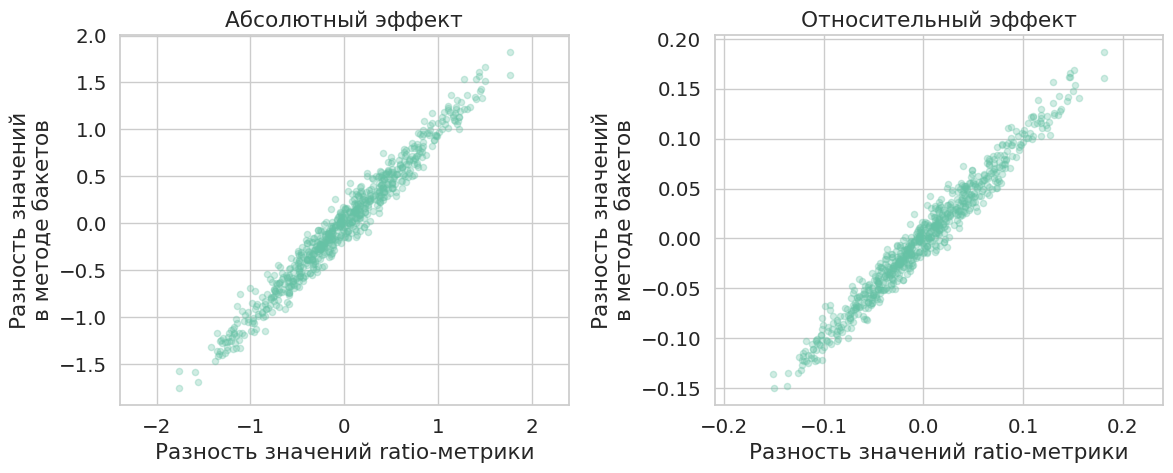

In [ ]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nв методе бакетов')
    plt.title(title)
    plt.axis('equal')

plt.tight_layout()

## 20 батчей:

In [ ]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample,
    metrics=[ratio_metric, lambda x, y : bucket_metric(x, y, num_bucks = 20)],
    target_name='session_lengths',
    n_iter=n_iter,
    sample_size=sample_size
)

  0%|          | 0/700 [00:00<?, ?it/s]

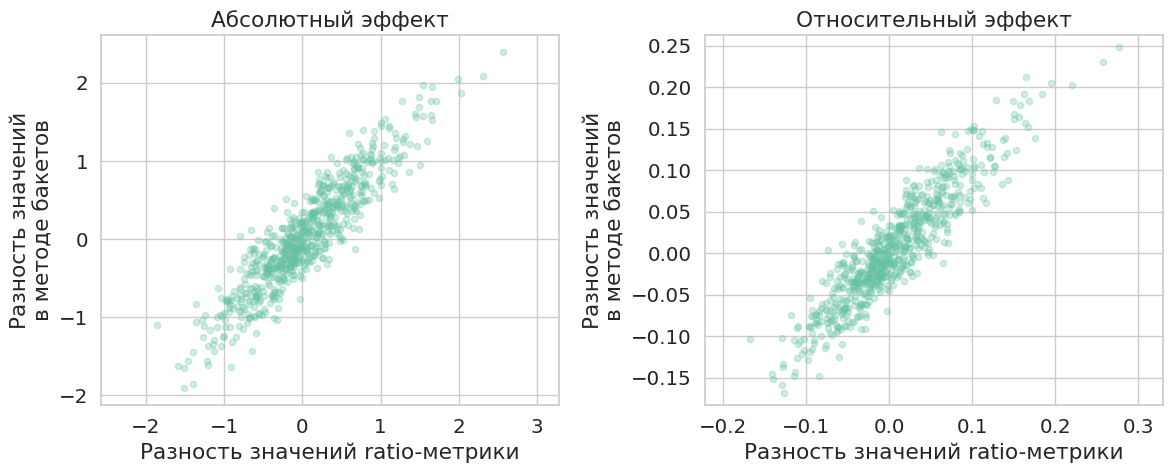

In [ ]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nв методе бакетов')
    plt.title(title)
    plt.axis('equal')

plt.tight_layout()

## 30 батчей:

In [ ]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample,
    metrics=[ratio_metric, lambda x, y : bucket_metric(x, y, num_bucks = 30)],
    target_name='session_lengths',
    n_iter=n_iter,
    sample_size=sample_size
)

  0%|          | 0/700 [00:00<?, ?it/s]

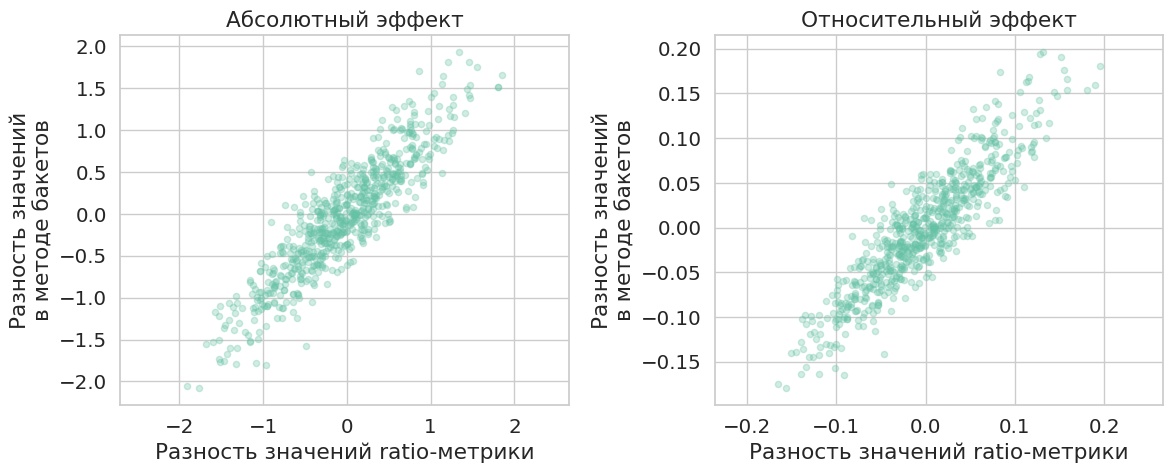

In [ ]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nв методе бакетов')
    plt.title(title)
    plt.axis('equal')

plt.tight_layout()

## 50 батчей:

In [ ]:
values_absolute, values_relative = metric_sampler(
    generate_session_sample,
    metrics=[ratio_metric, lambda x, y : bucket_metric(x, y, num_bucks = 50)],
    target_name='session_lengths',
    n_iter=n_iter,
    sample_size=sample_size
)

  0%|          | 0/700 [00:00<?, ?it/s]

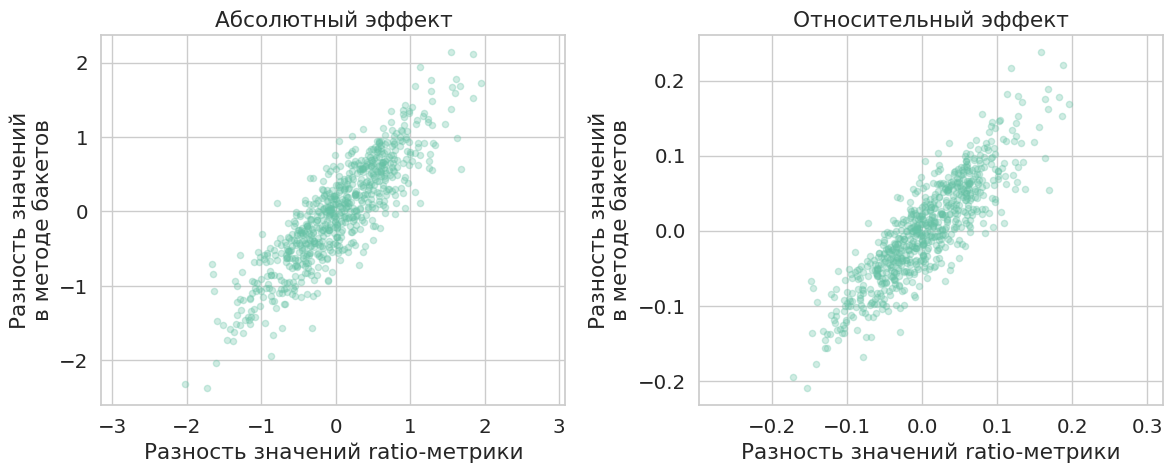

In [ ]:
plt.figure(figsize=(12, 5))
for i, value, title in zip(
    [1, 2],
    [values_absolute, values_relative],
    ['Абсолютный эффект', 'Относительный эффект']
):
    plt.subplot(1, 2, i)
    plt.scatter(value[0], value[1], s=20, alpha=0.3)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nв методе бакетов')
    plt.title(title)
    plt.axis('equal')

plt.tight_layout()

## .

В каком случае можно говорить о приближенной сонаправленности?

Ответ: Можно только при 10 и 20 бакетах - там маленькая ширина прямой в осях (разность значений ratio-метрики)-(Разность значений в методе бакетов), однако в остальных случаях - ширина этой прямой довольно большая и много точек в 2-ой и 4-ой четвертях графика

**2.** Давай все же попробуем сделать CUPED в методе бакетов

Для начала внедрим CUPED в метод бакетов. Не забудем, что CUPED-преобразование необходимо применять непосредственно к бакетам, а не к исходным пользователям.

## Функции:

In [ ]:
def generate_session_sample(
    n_users=100,
    min_session_count=0,
    max_session_count=30,
    effect=0,
    user_parameters=None
):
    if user_parameters is None:
        user_parameters = np.random.uniform(size=n_users, low=1, high=20)

    user_session_counts = np.random.randint(
        size=n_users, low=min_session_count, high=max_session_count + 1
    )

    users = []
    session_lengths = []
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            ) * (1 + effect)
        )

    return pd.DataFrame({"user_id": users, "session_lengths": session_lengths})

def generate_pre_post_samples(n_users=100, effect=0, num_buckets=20, **kwargs):
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    pre_data = generate_session_sample(n_users=n_users, user_parameters=user_parameters, effect=0, **kwargs)
    post_data = generate_session_sample(n_users=n_users, user_parameters=user_parameters, effect=effect, **kwargs)
    return pre_data, post_data

def cuped_bucket_transform(pre_data, post_data, num_buckets=20):
    for df in [pre_data, post_data]:
        df["bucket"] = df["user_id"].apply(lambda x: abs(hash(x)) % num_buckets)

    pre_agg = pre_data.groupby("bucket")["session_lengths"].sum().reset_index()
    post_agg = post_data.groupby("bucket")["session_lengths"].sum().reset_index()

    merged = pd.merge(pre_agg, post_agg, on="bucket", suffixes=("_pre", "_post"))

    cov_matrix = np.cov(merged["session_lengths_post"], merged["session_lengths_pre"])
    theta = cov_matrix[0,1] / cov_matrix[1,1]
    merged["cuped"] = merged["session_lengths_post"] - theta*(merged["session_lengths_pre"] - merged["session_lengths_pre"].mean())

    return merged["cuped"].values

def generate_cuped_transform(num_buckets=20, effect=0, **kwargs):
    pre_data, post_data = generate_pre_post_samples(effect=effect, **kwargs)
    return cuped_bucket_transform(pre_data, post_data, num_buckets=num_buckets)

def generate_bucket_transform(num_buckets=20, effect=0, **kwargs):
    data = generate_session_sample(effect=effect, **kwargs)
    return bucket_transform(data, "session_lengths", num_buckets=num_buckets)["values"].values



## .

Теперь провалидируем применение CUPED в методе бакетов на предмет контролирования ошибки 1 рода. Как и раньше, бери какую-нибудь функцию AA-теста с занятия.

*Не забудь, что итерации валидации можно легко параллелить, а ведь их надо сделать достаточно большое количество.*

In [ ]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 1000  # Размер выборок
n_iter = 1000  # Количество итераций валидации
feature = 'session_lengths'

## 10 бакетов:

                           Метод бакетов БЕЗ CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

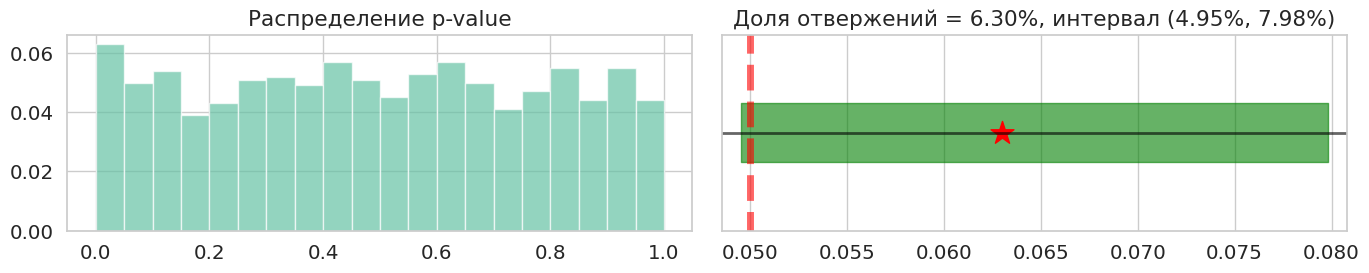

                           Метод бакетов С CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

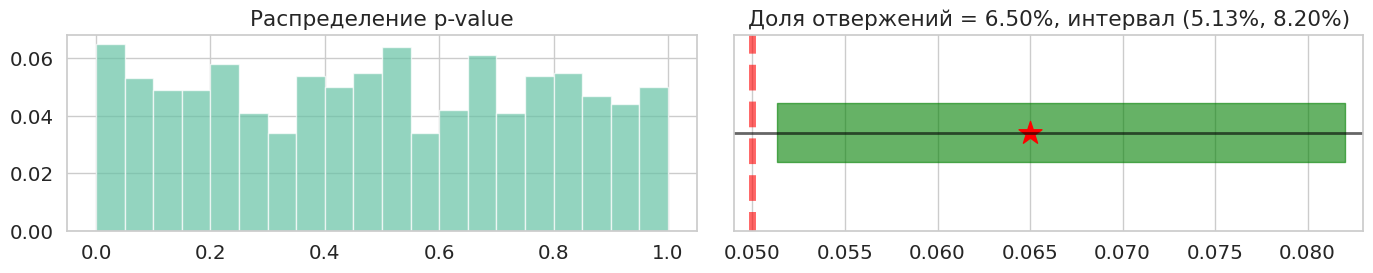

(0.065, (0.051323770569062045, 0.08200550931337092))

In [ ]:
print('                           Метод бакетов БЕЗ CUPED')
buckets_quantity = 10
# !НЕ! CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)
print('                           Метод бакетов С CUPED')
# CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)

## 20 бакетов:

                           Метод бакетов БЕЗ CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

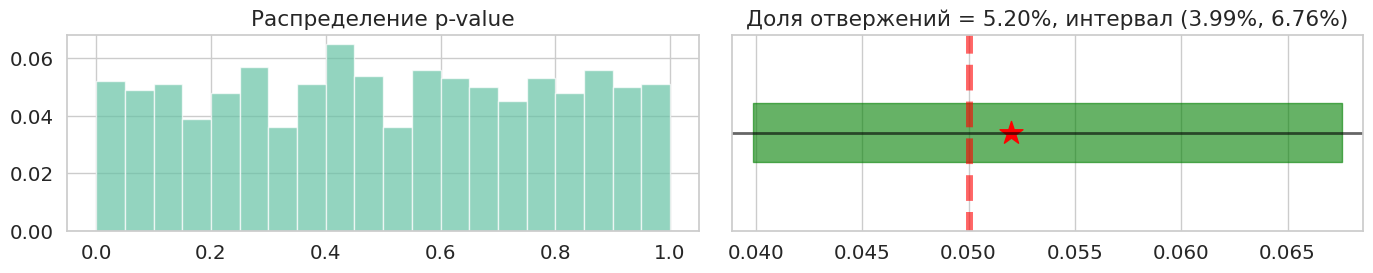

                           Метод бакетов C CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

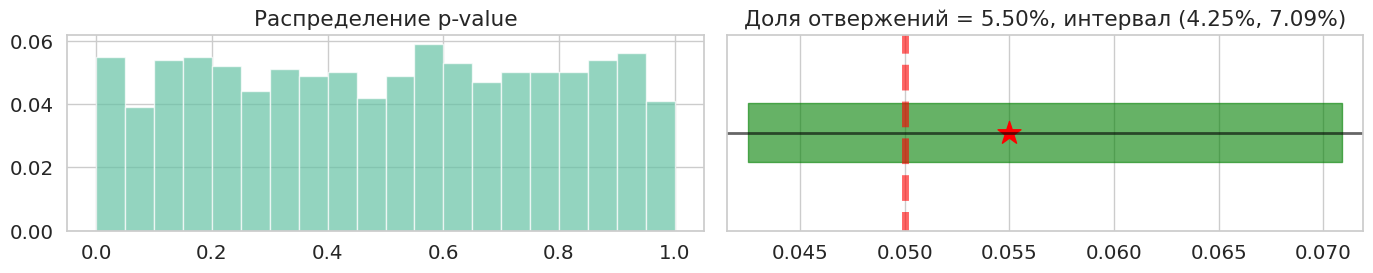

(0.055, (0.04249742737476844, 0.07090838767737563))

In [ ]:
print('                           Метод бакетов БЕЗ CUPED')
buckets_quantity = 20
# !НЕ! CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)
print('                           Метод бакетов C CUPED')
# CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)

## 30 бакетов:

                           Метод бакетов БЕЗ CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

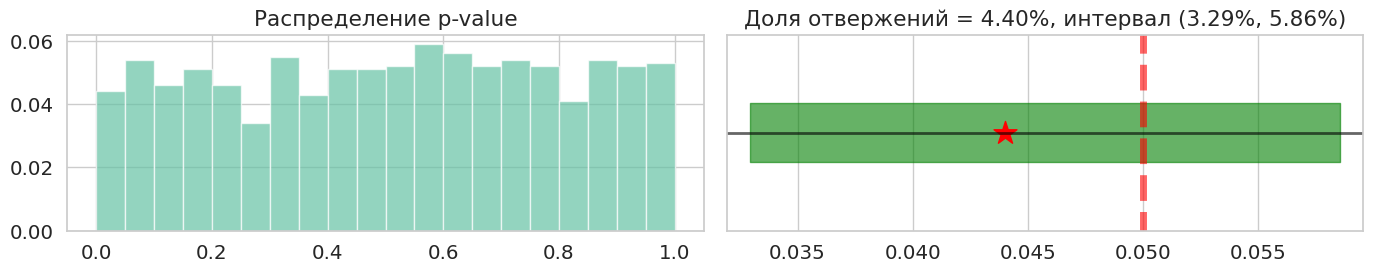

                           Метод бакетов C CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

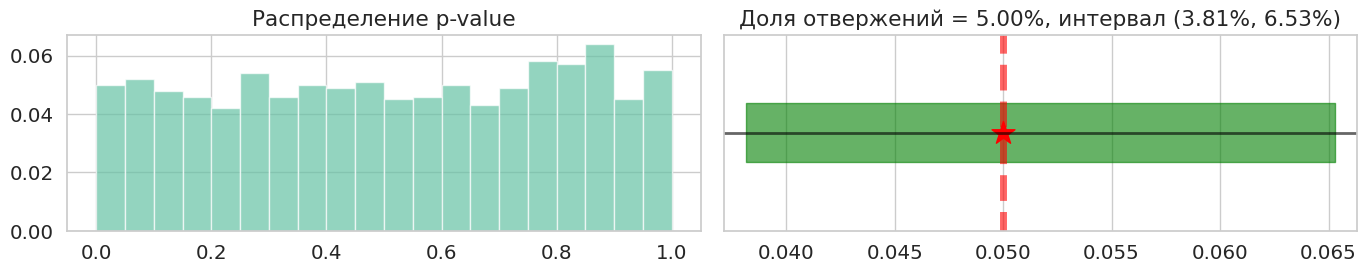

(0.05, (0.03813026239274881, 0.06531382024425081))

In [ ]:
print('                           Метод бакетов БЕЗ CUPED')
buckets_quantity = 30
# !НЕ! CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)
print('                           Метод бакетов C CUPED')
# CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)

## 50 бакетов:

                           Метод бакетов БЕЗ CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

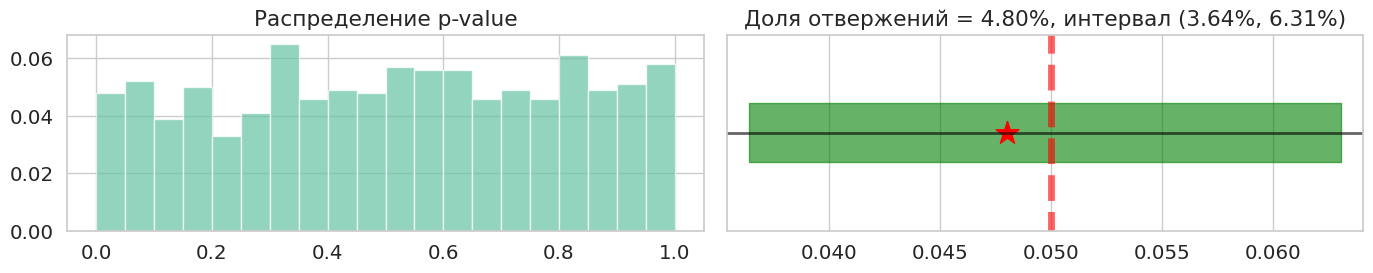

                           Метод бакетов C CUPED


  0%|          | 0/1000 [00:00<?, ?it/s]

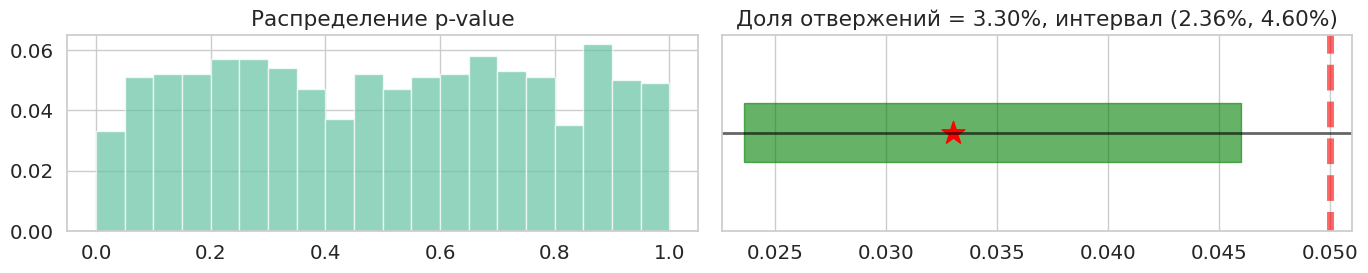

(0.033, (0.0235929279584269, 0.045981264467081596))

In [ ]:
print('                           Метод бакетов БЕЗ CUPED')
buckets_quantity = 50
# !НЕ! CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_bucket_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)

print('                           Метод бакетов C CUPED')
# CUPED
run_experiments(
    test=ttest_ind,
    generate_sample_x=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    generate_sample_y=lambda size: generate_cuped_transform(n_users=size, effect=0, num_buckets=buckets_quantity),
    n_iter=n_iter
)

## .

Для какого количества бакетов выполнены одновременно первые два условия из перечисленных вначале?

Ответ: Выполнилось для 20 бакетов (хотя и с натяжкой по поводу сонаправленности), что логично с точки зрения валидации, так как 10 бакетов может быть маловато, но и при этом большее количество бакетов 'ухудшает сонаправленность'

**3.** Оценим мощность соответствующих тестов для размеров эффекта от 1% до 5%. Сравним ее с CUPED в методе линеаризации.

## функция с линеаризацией

In [ ]:
def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users

def linearization_ratio_ttest(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    """

    control_data, test_data = linearization(
        # Порядок групп важен
        control_data,
        test_data,
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    name = "linearization_values"

    # Порядок групп важен
    return sps.ttest_ind(test_data[name], control_data[name])

############################################################################################################################################ не с семинара:

def run_power_comparison(n_buckets=20, effects=np.linspace(0.01, 0.05, 5), n_iter=1000, sample_size=1000):
    bucket_powers = []
    cuped_powers = []
    linear_powers = []

    config = {
        'n_users': sample_size,
    }

    def bucket_generator(effect):
        return generate_bucket_transform(num_buckets=n_buckets, effect=effect, **config)

    def cuped_generator(effect):
        return generate_cuped_transform(num_buckets=n_buckets, effect=effect, **config)

    for effect in tqdm(effects):
        power_est, (left, right) = run_experiments(
            test=ttest_ind,
            generate_sample_x=lambda size: bucket_generator(0),
            generate_sample_y=lambda size: bucket_generator(effect),
            n_iter=n_iter,
            draw=False
        )
        bucket_powers.append(power_est)

        power_est, (left, right) = run_experiments(
            test=ttest_ind,
            generate_sample_x=lambda size: cuped_generator(0),
            generate_sample_y=lambda size: cuped_generator(effect),
            n_iter=n_iter,
            draw=False
        )
        cuped_powers.append(power_est)

        power_est, (left, right) = run_experiments(
            test=linearization_ratio_ttest,
            generate_sample_x=lambda size: generate_session_sample(size),
            generate_sample_y=lambda size: generate_session_sample(size, effect=effect),
            n_iter=n_iter,
            draw=False
        )
        linear_powers.append(power_est)

    plt.figure(figsize=(10, 6))
    plt.plot(effects, bucket_powers, marker='o', label=f'Бакеты ({n_buckets})')
    plt.plot(effects, cuped_powers, marker='o', label='CUPED бакеты')
    plt.plot(effects, linear_powers, marker='o', label='Линеаризация')

    plt.xlabel('Размер эффекта')
    plt.ylabel('Мощность теста')
    plt.title(f'Сравнение методов ({n_buckets} бакетов)')
    plt.legend()
    plt.grid(True)
    plt.show()

def cuped_bucket_transform(pre_data, post_data, num_buckets=20):
    for df in [pre_data, post_data]:
        df['bucket'] = df['user_id'].apply(lambda x: abs(hash(x)) % num_buckets)

    pre_agg = pre_data.groupby('bucket')['session_lengths'].agg(['sum', 'count'])
    post_agg = post_data.groupby('bucket')['session_lengths'].agg(['sum', 'count'])

    merged = pre_agg.join(post_agg, lsuffix='_pre', rsuffix='_post')

    theta = np.cov(merged['sum_post'], merged['sum_pre'])[0,1] / np.var(merged['sum_pre'])
    merged['cuped'] = merged['sum_post'] - theta*(merged['sum_pre'] - merged['sum_pre'].mean())

    return merged['cuped'].values

def generate_pre_post_samples(n_users=1000, effect=0, num_buckets=20):
    user_params = np.random.gamma(shape=2, scale=5, size=n_users)
    pre_data = generate_session_sample(n_users=n_users, user_parameters=user_params, effect=0)
    post_data = generate_session_sample(n_users=n_users, user_parameters=user_params, effect=effect)
    return pre_data, post_data

def generate_cuped_transform(**kwargs):
    pre, post = generate_pre_post_samples(**kwargs)
    return cuped_bucket_transform(pre, post, kwargs.get('num_buckets', 20))

## .

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

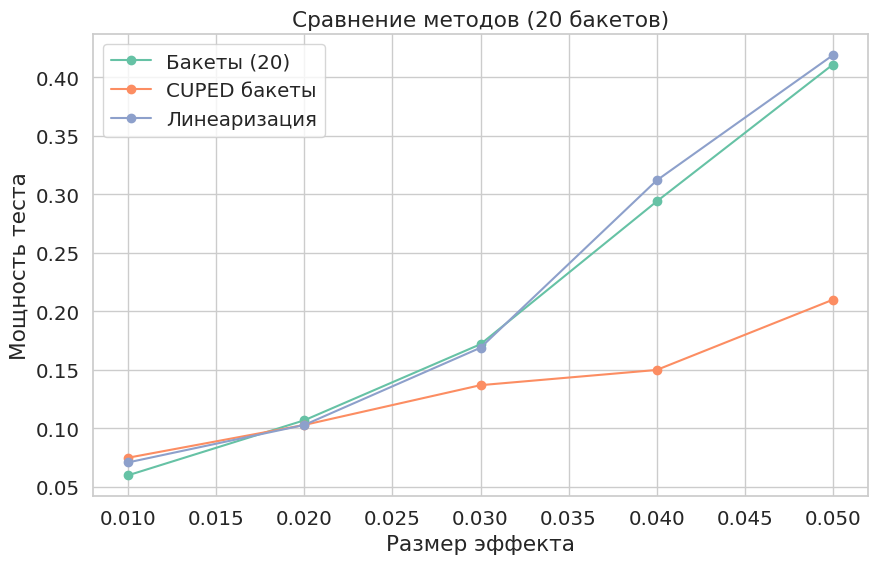

In [ ]:
run_power_comparison(n_buckets=20, n_iter=1000)

**Выводы:**

Видно что линеаризация почти всегда чуть лучше метода бакетов без CUPED, а еще видно, что при использовании CUPED для метода бакетов мощность заметно падает, что ухудшает наш АБ-тест, но, в отличии, от метода бакетов **для линеаризации CUPED применим**, причем хорошо

---

### Задача 2.

Поработаем с реальными данными.

Ранее мы делали дизайн АБ-теста на сайте Физтех.Статистики, причем в качестве метрики использовали среднюю по посетителям глубину просмотра страниц. Однако, на практике заказчики чаще интересуются глубиной просмотра страниц в среднем по всем посетителям сразу. Эту метрику мы и рассмотрим в данной задаче.

Поясним, почему она является ratio-метриками.

Дополнительно рассмотрим метрику длительности веб-сессий по всему сайту.

1) Глубина просмотра страниц в среднем по посетителям:
* Числитель: глубина просмотра страниц пользователями (сумма глубин)
* Знаменатель: количество пользователей

2) Длительность веб-сессий по всему сайту:
* Числитель: Сумма длин веб-сессий всех пользователей
* Знаменатель: количество пользователей

**1.** Проверим сонаправленность на реальных данных. Проверку нужно выполнить аналогично AA-тесту, совершая следующие итерации.
1. Выбрать случайный интервал времени фиксированной длины в истории визитов.
2. Выбрать две случайные группы фиксированного размера.
3. Посчитать по ним ratio-метрику и исследуемую метрику.

Загрузим данные и уберем префикс:

In [ ]:
data = pd.read_csv(
    "miptstats_metrica.tsv",
    sep="\t",
)

for column in data.columns:
    col = column.replace("ym:s:", "")
    data.rename(columns={column: col}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387353 entries, 0 to 387352
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   visitID              387353 non-null  float64
 1   clientID             387353 non-null  uint64 
 2   dateTimeUTC          387353 non-null  object 
 3   startURL             387338 non-null  object 
 4   endURL               387338 non-null  object 
 5   pageViews            387353 non-null  int64  
 6   visitDuration        387353 non-null  int64  
 7   isNewUser            387353 non-null  int64  
 8   bounce               387353 non-null  int64  
 9   regionCountry        382478 non-null  object 
 10  regionCity           326661 non-null  object 
 11  networkType          43035 non-null   object 
 12  browserLanguage      327934 non-null  object 
 13  browserCountry       224983 non-null  object 
 14  mobilePhone          73354 non-null   object 
 15  operatingSystemRo

In [ ]:
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])
data = data[["clientID", "dateTimeUTC", "pageViews", "visitDuration"]]
data.head(2)

,clientID,dateTimeUTC,pageViews,visitDuration
0,1568056026568729022,2020-01-01 03:28:50,1,1
1,1577864187752491163,2020-01-01 10:36:27,9,215


## Некоторые дополнительные функции:

In [ ]:
def test_simulation(test, generate_sample_x, generate_sample_y):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: pvalue
    """

    x = generate_sample_x(size=sample_size)
    y = generate_sample_y(size=sample_size)

    return test(x, y)[1]


def run_experiments(
    test,
    generate_sample_x,
    generate_sample_y=None,
    n_iter=10000,
    sample_size=1000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_y is None:
        generate_sample_y = generate_sample_x

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(test, generate_sample_x, generate_sample_y)
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

def bucket_transform(
    data,
    numerator_name="session_lengths",
    user_name="user_id",
    denominator_name=None,
    num_buckets=10,
):
    """
    Создает бакеты из данных.

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    num_buckets -- число бакетов

    Возвращает сгруппированные данные
    """

    if denominator_name is None:
        denominator_name = "ratio_denominator"
        data[denominator_name] = 1

    data["bucket"] = data[user_name].apply(lambda x: np.abs(hash(x)) % num_buckets)
    groupped_data = data.groupby(by="bucket")[[numerator_name, denominator_name]].sum()
    groupped_data["values"] = (
        groupped_data[numerator_name] / groupped_data[denominator_name]
    )
    return groupped_data


def generate_transform(
    n_users=100,
    min_session_count=0,
    max_session_count=30,
    num_buckets=10,
    effect=0,
):
    """
    Функция, объединяющая генерацию данных и их бакет-преобразование.

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    num_buckets -- число бакетов
    effect -- добавляемый эффект
    """

    data = generate_session_sample(
        n_users=n_users,
        min_session_count=min_session_count,
        max_session_count=max_session_count,
        effect=effect,
    )

    return bucket_transform(data, num_buckets=num_buckets)["values"]

def generate_users_data(n_users=100, max_session_count=15, effect=0):
    """
    Генерация данных пользовательских сессий и их агрегация по пользователям.

    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    """

    data = generate_session_sample(
        n_users=n_users, max_session_count=max_session_count, effect=effect
    )

    return data.groupby("user_id").mean()

def ratio_metric(data, numerator_name, denominator_name=None):
    """
    Вычисляет ratio-метрику

    data -- таблица данных
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    if denominator_name is None:
        return data[numerator_name].mean()
    else:
        return data[numerator_name].sum() / data[denominator_name].sum()


def users_mean_metric(
    data, numerator_name, user_name="user_id", denominator_name=None
):
    """
    Вычисляет метрики отдельно по пользователям

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    groupped_data = data.groupby(user_name)

    if denominator_name is None:
        return groupped_data.mean()[numerator_name].mean()
    else:
        users_values = (
            groupped_data[numerator_name].sum()
            / groupped_data[denominator_name].sum()
        )
        return users_values.mean()

def metric_sampler(
    generate_sample, metrics, target_name, n_iter=10000, sample_size=1000
):
    """
    Генерация значений разности средних по группам для разных метрик.

    Аргументы:
    generate_sample -- функции для семплирования выборок
    metrics -- список метрик
    target_name -- поле для вычисления метрики
    n_iter -- количество итераций
    sample_size -- размер выборок
    """

    values_absolute = np.zeros((len(metrics), n_iter))
    values_relative = np.zeros((len(metrics), n_iter))

    # Проведение экспериментов
    for i in tqdm(range(n_iter)):
        x = generate_sample(sample_size)
        y = generate_sample(sample_size)

        for j, metric in enumerate(metrics):
            test = metric(x, target_name)
            control = metric(y, target_name)
            values_absolute[j, i] = test - control
            values_relative[j, i] = (test - control) / control

    return values_absolute, values_relative

def generate_session_sample(
    n_users=100, min_session_count=0, max_session_count=30, effect=0
):
    """
    Генерация данных пользовательских сессий

    n_users -- количество пользователей
    min_session_count -- минимальное количество сессий на пользователя
    max_session_count -- максимальное количество сессий на пользователя
    effect -- добавляемый эффект
    """

    # Параметр формы гамма-распределения для каждого пользователя
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)
    # Количество сессий каждого пользователя
    user_session_counts = np.random.randint(
        size=n_users, low=min_session_count, high=max_session_count + 1
    )

    users = []
    session_lengths = []
    # Для каждого пользователя генерируем все его сессии
    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            * (1 + effect)
        )

    # Заносим в табличку
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
        }
    )

    return data

def bucket_metric(
    data, numerator_name, user_name="user_id", denominator_name=None
):
    """
    Вычисляет метрики отдельно по бакетам

    data -- данные
    numerator_name -- имя колонки-числителя ratio-метрики
    user_name -- имя колонки с id пользователей
    denominator_name -- имя колонки-знаменателя ratio-метрики
    """

    bucket_data = bucket_transform(
        data,
        numerator_name,
        user_name=user_name,
        denominator_name=denominator_name,
        num_buckets=10,
    )

    return bucket_data["values"].mean()

def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users

def linearization_ratio_ttest(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    """

    control_data, test_data = linearization(
        control_data,
        test_data,
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    name = "linearization_values"

    return sps.ttest_ind(test_data[name], control_data[name])

def linearization_metric(data, numerator_name):
    return data["linearization_values"].mean()

def generate_session_sample_with_prepilot(
    n_users=100, mean_session_count=15, effect=0
):
    """
    Генерация данных пользовательских сессий для двух последовательных периодов.

    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    """

    user_parameters = np.random.uniform(size=n_users, low=1, high=20)

    user_session_counts = 2 + np.random.poisson(
        size=n_users, lam=2 * mean_session_count
    )

    users = []
    period = []
    session_lengths = []

    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            + effect
        )

        count = np.random.binomial(n=user_session_counts[user_id], p=0.5)

        count = min(max(1, count), user_session_counts[user_id] - 1)

        period += [1] * count
        period += [0] * (user_session_counts[user_id] - count)

    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
            "period": np.array(period, dtype=int),
        }
    )

    return data

def cuped_transform(
    x_data,
    y_data,
    sample_name="pilot",
    cuped_name="cuped",
    covariate_name="prepilot",
    paired=False,
    return_theta=False,
):
    """
    Выполняет CUPED-преобразование.

    :param x_data, y_data: данные по двум группам
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    """

    if paired:
        theta = (
            np.cov(
                x_data[covariate_name] - y_data[covariate_name],
                x_data[sample_name] - y_data[sample_name],
            )[0, 1]
        ) / ((x_data[covariate_name] - y_data[covariate_name]).var(ddof=0))

    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1]
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0)
            + y_data[covariate_name].var(ddof=0)
        )

    x_data[cuped_name] = x_data[sample_name] - theta * x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta * y_data[covariate_name]

    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data

def linearization_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "linearization_values_cuped" if cuped else "linearization_values"

    control_users_pilot, test_users_pilot = linearization(
        control_data[control_data["period"] == 1],
        test_data[test_data["period"] == 1],
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    if cuped:
        control_users_prepilot, test_users_prepilot = linearization(
            control_data[control_data["period"] == 0],
            test_data[test_data["period"] == 0],
            numerator_name=numerator_name,
            denominator_name=denominator_name,
            user_name=user_name,
            eta=eta,
        )

        control_users_pilot = control_users_pilot.join(
            control_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )
        test_users_pilot = test_users_pilot.join(
            test_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )

        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="linearization_values",
            cuped_name=name,
            covariate_name="linearization_values_prepilot",
        )

    else:
        control_data, test_data = control_users_pilot, test_users_pilot

    res = sps.ttest_ind(test_data[name], control_data[name])
    stat = res.statistic
    pvalue = res.pvalue

    left_bound, right_bound = res.confidence_interval()

    coef = eta * control_data[denom].mean() + (1 - eta) * test_data[denom].mean()
    left_bound /= coef
    right_bound /= coef

    return stat, pvalue, left_bound, right_bound

def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    if relative_effect:
        test_data[feature_values] *= 1 + effect * (test_data["period"] == 1)
    else:
        test_data[feature_values] += effect * (test_data["period"] == 1)

    return test(control_data, test_data)[1]



def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    # Оценка вероятности ошибки первого рода
    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals=show_pvals,
            pvals=pvals,
            alpha=alpha,
            figsize=figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)

## Реализованные функции:

In [ ]:
def select_time_window(data, window_length_weeks):
    window_days = window_length_weeks * 7
    dates = pd.to_datetime(data['dateTimeUTC'])
    min_date = dates.min()
    max_date = dates.max()
    delta = (max_date - min_date).days - window_days
    if delta <= 0:
        raise ValueError("Insufficient data")
    start_days = np.random.randint(0, delta)
    start_date = min_date + pd.Timedelta(days=start_days)
    end_date = start_date + pd.Timedelta(days=window_days)
    mask = (dates >= start_date) & (dates < end_date)
    return data[mask].copy()

def split_users(data, group_size_percent):
    users = data['clientID'].unique()
    n_users = len(users)
    group_size = int(n_users * group_size_percent / 100)
    selected = np.random.choice(users, 2*group_size, replace=False)
    return data[data['clientID'].isin(selected[:group_size])], data[data['clientID'].isin(selected[group_size:2*group_size])]

def create_aggregation_test(metric):
    def test(data_a, data_b):
        users_a = data_a.groupby('clientID')[metric].sum().values
        users_b = data_b.groupby('clientID')[metric].sum().values
        if len(users_a) < 2 or len(users_b) < 2:
            return 1.0
        _, p_value = sps.ttest_ind(users_a, users_b, equal_var=False)
        return p_value
    return test

def create_bucket_test(metric, num_buckets=10):
    def test(data_a, data_b):
        def bucket_metrics(data):
            users = data['clientID'].unique()
            buckets = pd.util.hash_array(users) % num_buckets
            data_buckets = pd.DataFrame({'clientID': users, 'bucket': buckets})
            merged = pd.merge(data, data_buckets, on='clientID')
            bucket_sum = merged.groupby('bucket')[metric].sum()
            bucket_count = merged.groupby('bucket')['clientID'].nunique()
            return (bucket_sum / bucket_count).values
        a_metrics = bucket_metrics(data_a)
        b_metrics = bucket_metrics(data_b)
        if len(a_metrics) == 0 or len(b_metrics) == 0:
            return 1.0
        _, p_value = sps.ttest_ind(a_metrics, b_metrics, equal_var=False)
        return p_value
    return test

def create_linearization_test(metric):
    def test(data_a, data_b):
        combined = pd.concat([data_a, data_b])
        total = combined[metric].sum()
        users_total = combined['clientID'].nunique()
        kappa = total / users_total
        def linearize(data):
            user_sums = data.groupby('clientID')[metric].sum().values
            return user_sums - kappa
        a_lin = linearize(data_a)
        b_lin = linearize(data_b)
        if len(a_lin) < 2 or len(b_lin) < 2:
            return 1.0
        _, p_value = sps.ttest_ind(a_lin, b_lin, equal_var=False)
        return p_value
    return test

def run_experiment_for_config(data, group_size, window_length, metric, method, n_iter=1000):
    test_func = {
        'aggregation': create_aggregation_test(metric),
        'bucket': create_bucket_test(metric),
        'linearization': create_linearization_test(metric)
    }[method]

    def generate_pair():
        try:
            window_data = select_time_window(data, window_length)
            a, b = split_users(window_data, group_size)
            return a, b
        except:
            return pd.DataFrame(), pd.DataFrame()

    p_values = []
    for _ in tqdm(range(n_iter)):
        a, b = generate_pair()
        if a.empty or b.empty:
            continue
        p_values.append(test_func(a, b))

    reject_prob, left, right = estimate_reject_prob(
        sum(np.array(p_values) < 0.05), len(p_values)
    )
    return reject_prob, left, right

def compare_metrics(data, group_size, window_length, metric, n_iter=100):
    """
    Сравнивает разности метрик для разных методов с разностями ratio-метрик.

    Аргументы:
    data -- исходные данные
    group_size -- размер группы (в процентах)
    window_length -- длина временного интервала (в неделях)
    metric -- метрика (например, 'pageViews' или 'visitDuration')
    n_iter -- количество итераций
    """
    def ratio_metric(data):
        return data[metric].sum() / data['clientID'].nunique()

    def aggregation_metric(data):
        return data.groupby('clientID')[metric].sum().mean()

    def bucket_metric(data):
        users = data['clientID'].unique()
        buckets = pd.util.hash_array(users) % 10
        data_buckets = pd.DataFrame({'clientID': users, 'bucket': buckets})
        merged = pd.merge(data, data_buckets, on='clientID')
        bucket_sum = merged.groupby('bucket')[metric].sum()
        bucket_count = merged.groupby('bucket')['clientID'].nunique()
        return (bucket_sum / bucket_count).mean()

    def linearization_metric(data):
        total = data[metric].sum()
        users_total = data['clientID'].nunique()
        kappa = total / users_total
        user_sums = data.groupby('clientID')[metric].sum().values
        return (user_sums - kappa).mean()

    ratio_diffs = []
    aggregation_diffs = []
    bucket_diffs = []
    linearization_diffs = []

    for _ in tqdm(range(n_iter)):
        try:
            window_data = select_time_window(data, window_length)
            group_a, group_b = split_users(window_data, group_size)

            ratio_diff = ratio_metric(group_a) - ratio_metric(group_b)
            aggregation_diff = aggregation_metric(group_a) - aggregation_metric(group_b)
            bucket_diff = bucket_metric(group_a) - bucket_metric(group_b)
            linearization_diff = linearization_metric(group_a) - linearization_metric(group_b)

            ratio_diffs.append(ratio_diff)
            aggregation_diffs.append(aggregation_diff)
            bucket_diffs.append(bucket_diff)
            linearization_diffs.append(linearization_diff)
        except:
            continue

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(ratio_diffs, aggregation_diffs, s=18, alpha=0.5)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nагрегированной метрики')
    plt.title('Агрегация по пользователям')
    plt.axis('equal')
    # plt.xlim((-1,1))
    # plt.ylim((-1,1))

    plt.subplot(1, 3, 2)
    plt.scatter(ratio_diffs, bucket_diffs, s=18, alpha=0.5)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nметода бакетов')
    plt.title('Метод бакетов')
    plt.axis('equal')
    # plt.xlim((-30,30))
    # plt.ylim((-30,30))

    plt.subplot(1, 3, 3)
    plt.scatter(ratio_diffs, linearization_diffs, s=18, alpha=0.5)
    plt.xlabel('Разность значений ratio-метрики')
    plt.ylabel('Разность значений\nлинеаризованной метрики')
    plt.title('Линеаризация')
    plt.axis('equal')
    # plt.xlim((-10,10))
    # plt.ylim((-10,10))

    plt.tight_layout()
    plt.show()

## Проведем валидацию:

In [ ]:
configs = [
    (10, 3), (10, 5), (20, 3), (20, 5)
]
metrics = ['pageViews', 'visitDuration']
methods = ['aggregation', 'bucket', 'linearization']

results = []
for group_size, window in configs:
    for metric in metrics:
        for method in methods:
            prob, left, right = run_experiment_for_config(
                data, group_size, window, metric, method, n_iter=1000
            )
            results.append({
                'group_size': group_size,
                'window': window,
                'metric': metric,
                'method': method,
                'reject_prob': prob,
                'ci_lower': left,
                'ci_upper': right
            })

for res in results:
    print(f"Group: {res['group_size']}%, Window: {res['window']}w, Metric: {res['metric']}, Method: {res['method']}")
    print(f"Reject prob: {res['reject_prob']:.3f} ({res['ci_lower']:.3f}-{res['ci_upper']:.3f})")
    print()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Group: 10%, Window: 3w, Metric: pageViews, Method: aggregation
Reject prob: 0.029 (0.020-0.041)

Group: 10%, Window: 3w, Metric: pageViews, Method: bucket
Reject prob: 0.024 (0.016-0.035)

Group: 10%, Window: 3w, Metric: pageViews, Method: linearization
Reject prob: 0.032 (0.023-0.045)

Group: 10%, Window: 3w, Metric: visitDuration, Method: aggregation
Reject prob: 0.037 (0.027-0.051)

Group: 10%, Window: 3w, Metric: visitDuration, Method: bucket
Reject prob: 0.044 (0.033-0.059)

Group: 10%, Window: 3w, Metric: visitDuration, Method: linearization
Reject prob: 0.029 (0.020-0.041)

Group: 10%, Window: 5w, Metric: pageViews, Method: aggregation
Reject prob: 0.028 (0.019-0.040)

Group: 10%, Window: 5w, Metric: pageViews, Method: bucket
Reject prob: 0.038 (0.028-0.052)

Group: 10%, Window: 5w, Metric: pageViews, Method: linearization
Reject prob: 0.041 (0.030-0.055)

Group: 10%, Window: 5w, Metric: visitDuration, Method: aggregation
Reject prob: 0.044 (0.033-0.059)

Group: 10%, Window: 5w,

Все критери прошли валидацию! - доля отвержений меньше 0.05

Визуализируем все вышенаписанное для разного количества недель (3, 5), размера выборки (10%, 20%) для длительности и глубины:

In [ ]:
n_iter = 1000

# Для глубины:

## группа размера 10%, количетсво недель 3 и 5:

  0%|          | 0/1000 [00:00<?, ?it/s]

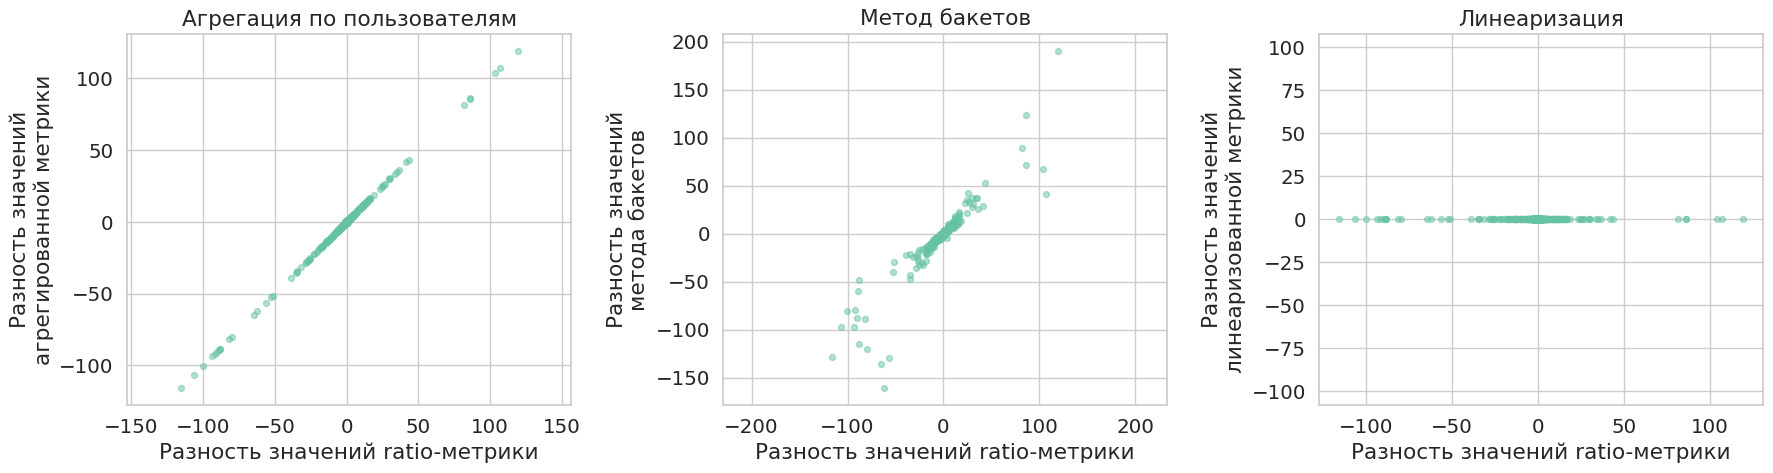

In [ ]:
weeks = 3
group_percent = 10
target_metric = 'pageViews'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

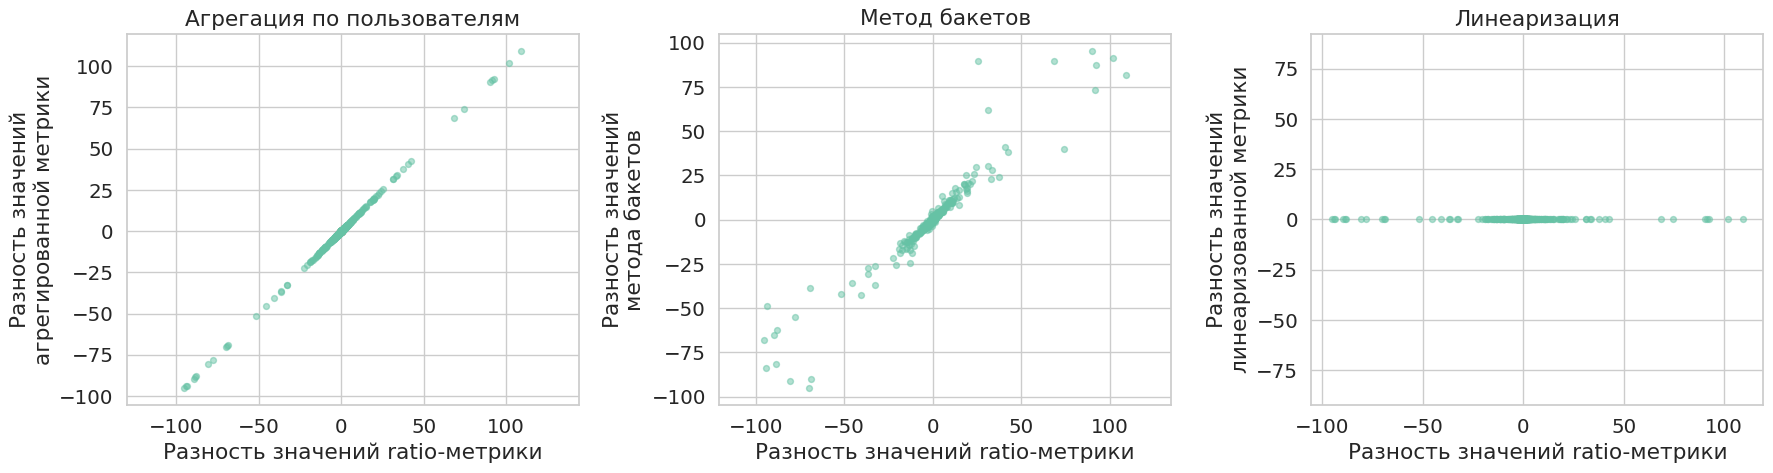

In [ ]:
weeks = 5
group_percent = 10
target_metric = 'pageViews'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

## группа размера 20%, количетсво недель 3 и 5:

  0%|          | 0/1000 [00:00<?, ?it/s]

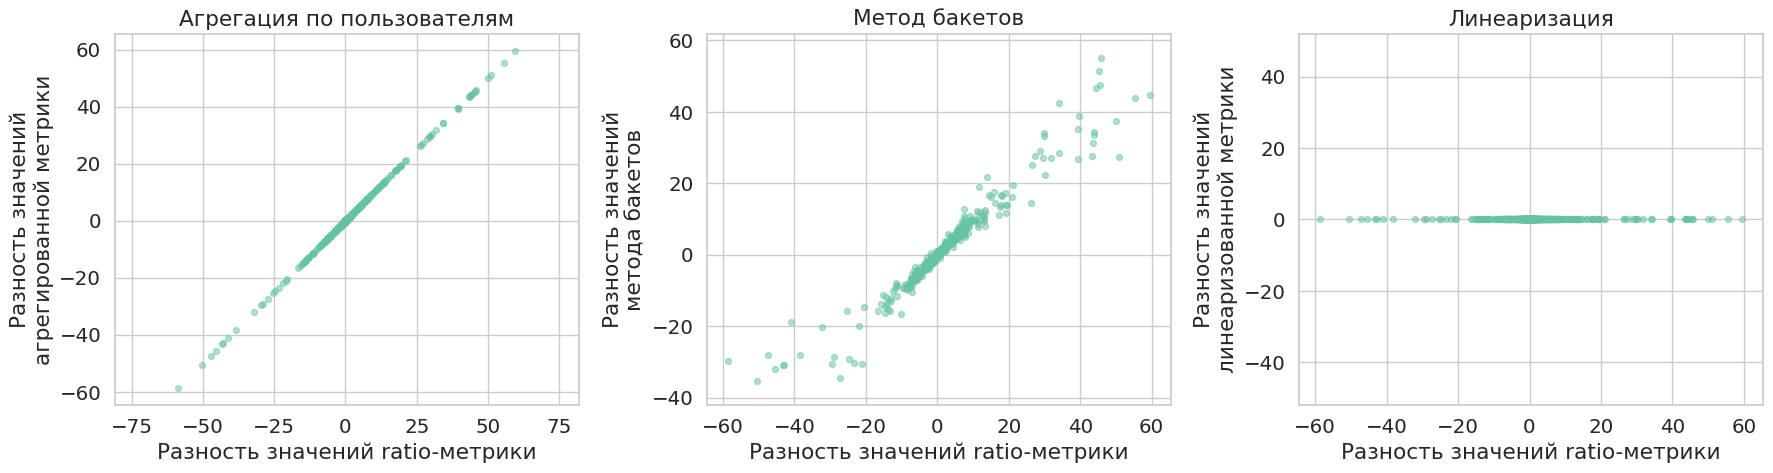

In [ ]:
weeks = 3
group_percent = 20
target_metric = 'pageViews'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

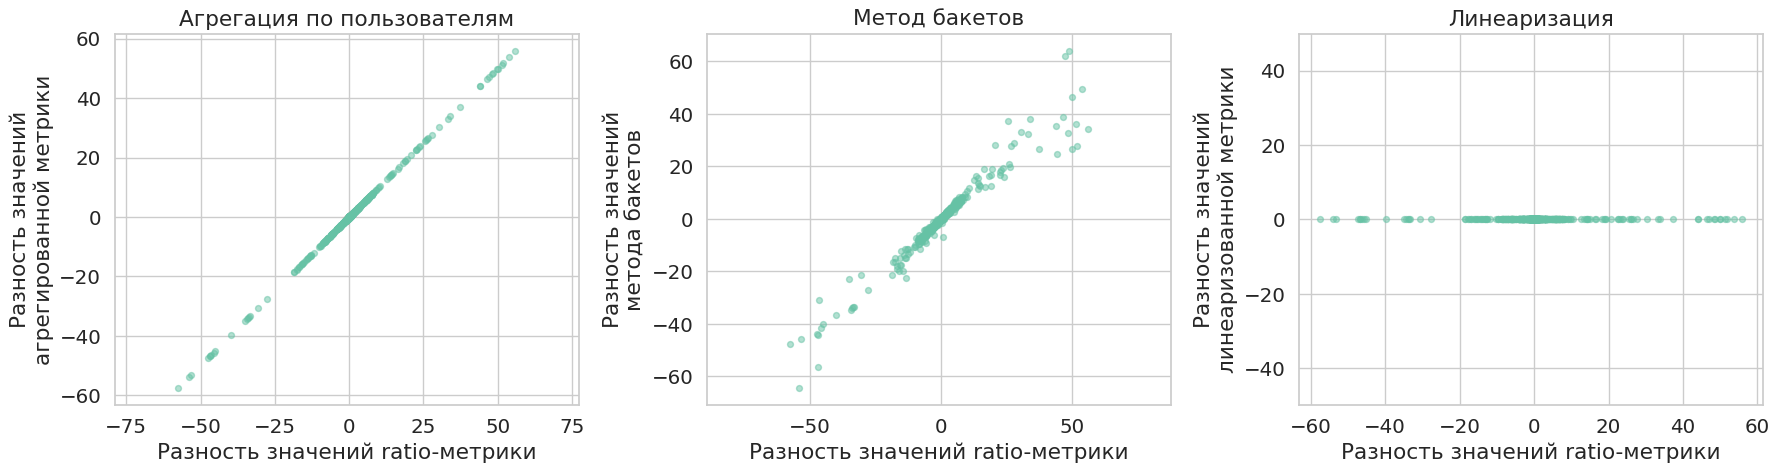

In [ ]:
weeks = 5
group_percent = 20
target_metric = 'pageViews'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

# Для длительности:

## группа размера 10%, количетсво недель 3 и 5:

  0%|          | 0/1000 [00:00<?, ?it/s]

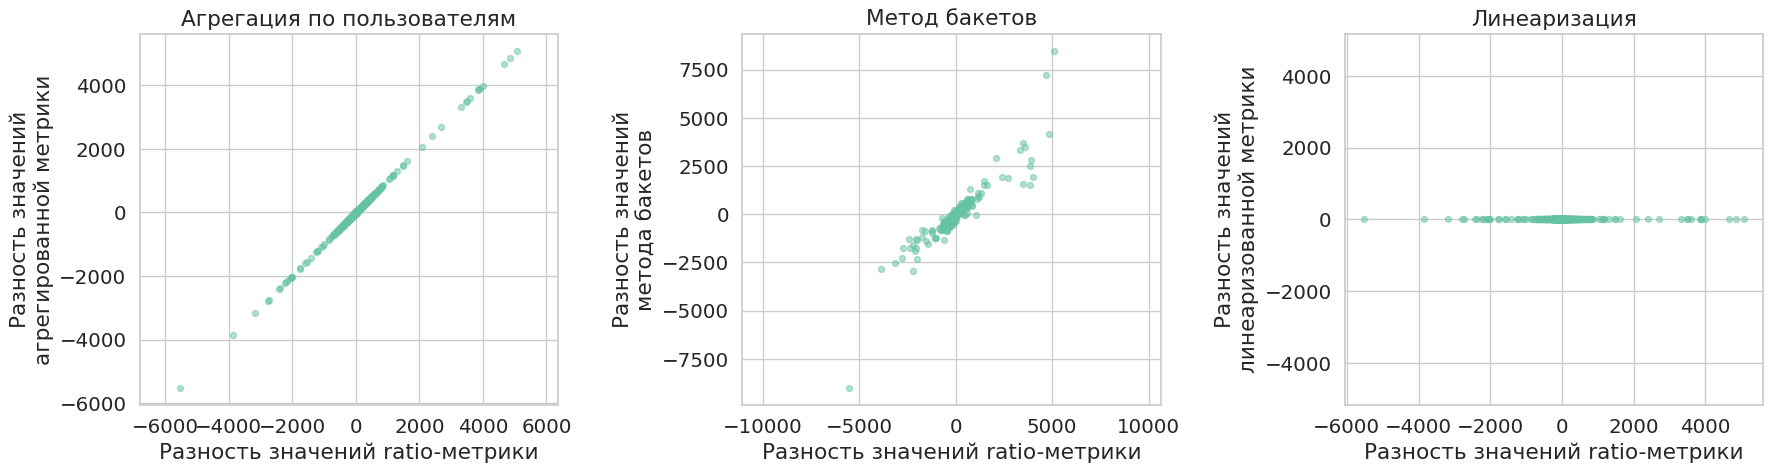

In [ ]:
weeks = 3
group_percent = 10
target_metric = 'visitDuration'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

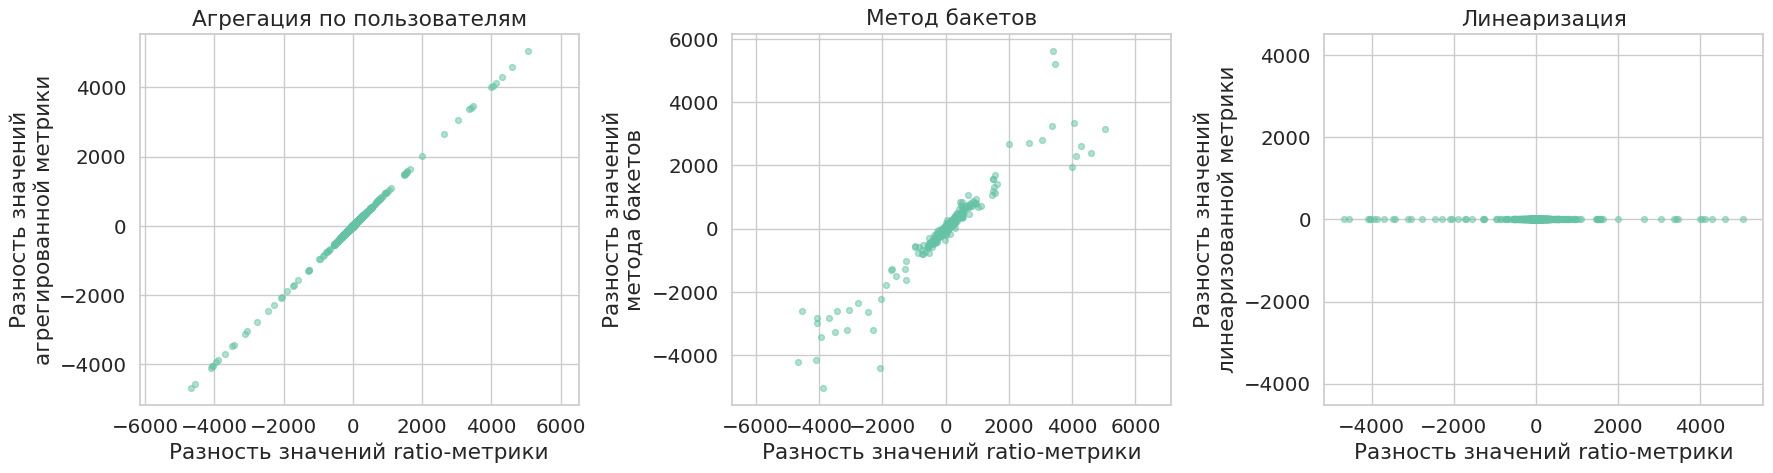

In [ ]:
weeks = 5
group_percent = 10
target_metric = 'visitDuration'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

## группа размера 20%, количетсво недель 3 и 5:

  0%|          | 0/1000 [00:00<?, ?it/s]

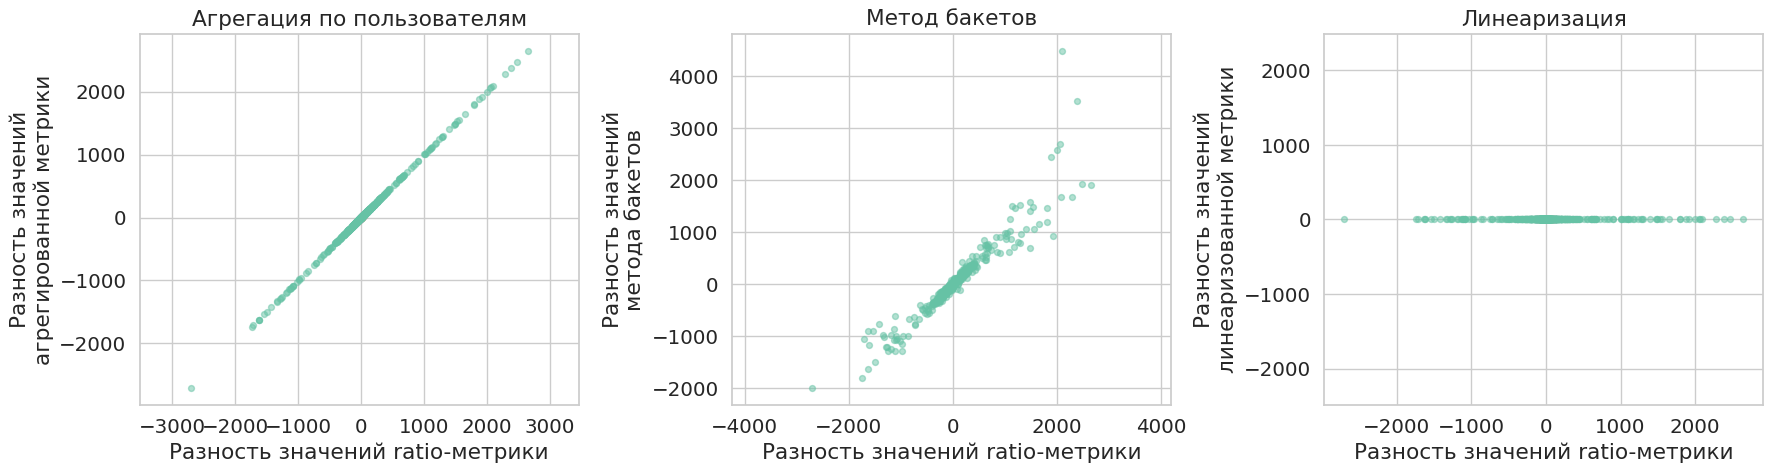

In [ ]:
weeks = 3
group_percent = 20
target_metric = 'visitDuration'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

  0%|          | 0/1000 [00:00<?, ?it/s]

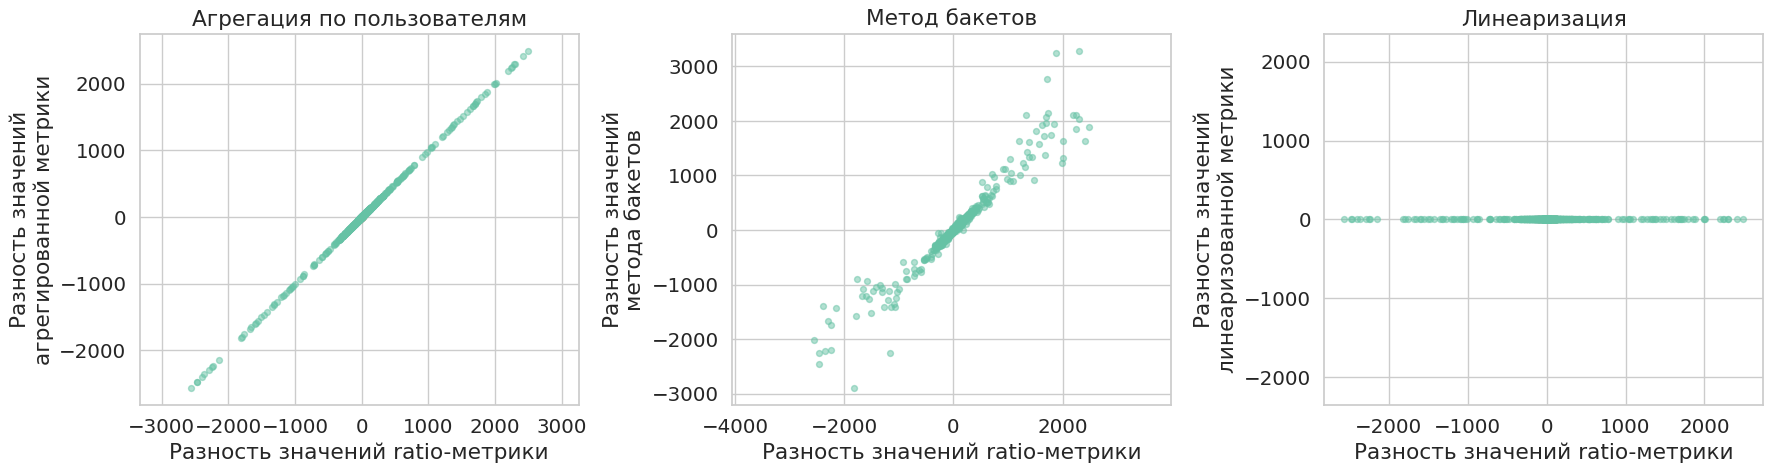

In [ ]:
weeks = 5
group_percent = 20
target_metric = 'visitDuration'

compare_metrics(data, group_size=group_percent, window_length=weeks, metric=target_metric, n_iter=n_iter)

# .

* При агрегации по пользователям линия очень узкая и соответвенно мало несонаправленных значений, из-за чего можно считать агрегацию по пользователям довольно хорошей процедурой
* При использовании метода бакетов линия не такая узкая, даже всегда широкая в нуле, что не есть хорошо и на отдалении от 0 дисперсия увеличивается
* При линеаризации прямая почти горизонтальна, однако видно небольшое утолщения в районе 0

**2.** Провалидируем эксперимент для линеаризации с CUPED и стратификацией.

По сути, сделать надо примерно то же самое, но добавить линеаризацию.

In [ ]:
data = pd.read_csv(
    "miptstats_metrica.tsv",
    sep="\t",
)

for column in data.columns:
    col = column.replace("ym:s:", "")
    data.rename(columns={column: col}, inplace=True)

data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])
data.head(2)

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserCountry,mobilePhone,operatingSystemRoot,browser,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,gb,NaN,gnu_linux,chrome,WebKit,2,1920,1080,1905,981
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,us,apple,ios_double,safari_mobile,WebKit,1,375,667,375,559


## Функции для валидации:

In [ ]:
def linearization(
    control_data,
    test_data,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
):
    """
    Реализация линеаризации ratio-метрики.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации

    Возвращает:
    control_users, test_users -- таблицу с поюзерными линеаризованными метриками,
    которые записаны в колонках linearization_values
    """

    if denominator_name is None:
        control_data = control_data.copy()
        test_data = test_data.copy()

        denominator_name = "ratio_denominator"
        control_data[denominator_name] = 1
        test_data[denominator_name] = 1

    # Коэффициент линеаризации
    kappa = (1 - eta) * ratio_metric(
        control_data, numerator_name, denominator_name
    ) + eta * ratio_metric(test_data, numerator_name, denominator_name)

    # Группируем по пользователям
    control_users = control_data.groupby(user_name).sum()
    test_users = test_data.groupby(user_name).sum()

    # Вычисляем линеаризованные метрики
    control_users["linearization_values"] = (
        control_users[numerator_name] - kappa * control_users[denominator_name]
    )
    test_users["linearization_values"] = (
        test_users[numerator_name] - kappa * test_users[denominator_name]
    )

    return control_users, test_users

def regression_ttest(
    x_data,
    y_data,
    cuped=False,
    stratified=False,
    sample_name="pilot",
    treatment_name="treatment",
    covariate_names=[],
    strat_names=[],
):
    """
    T-test с CUPED/без CUPED, со стратификацией/без реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param stratified: применять ли стратификацию
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат
    :param strat_names: массив имен стратификационных столбцов

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    x_data_cp = x_data.copy()
    y_data_cp = y_data.copy()

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])
    # удаляем ненужные столбцы из датасета
    if not cuped:
        covariate_names = []
    if not stratified:
        strat_names = []
    data = data[
        [treatment_name] + list(covariate_names) + list(strat_names) + [sample_name]
    ]

    # делаем стратификацию по нужным фичам
    data = pd.get_dummies(data, columns=strat_names)

    # определяем имена фичей, на которых будем обучать модель
    feature_names = list(set(data.columns) - set([sample_name]))

    # обучаем модель
    model = ols(f"{sample_name} ~ " + "+".join(feature_names), data=data).fit()
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, "t"]
    pvalue = summary.loc[treatment_name, "P>|t|"]
    left_bound = summary.loc[treatment_name, "[0.025"]
    right_bound = summary.loc[treatment_name, "0.975]"]
    return stat, pvalue, left_bound, right_bound

In [ ]:
def test_simulation(test, generate_sample_x, generate_sample_y):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: pvalue
    """

    x = generate_sample_x(size=sample_size)
    y = generate_sample_y(size=sample_size)

    return test(x, y)[1]


def run_experiments(
    test,
    generate_sample_x,
    generate_sample_y=None,
    n_iter=10000,
    sample_size=1000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_y is None:
        generate_sample_y = generate_sample_x

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(test, generate_sample_x, generate_sample_y)
        for _ in tqdm(range(n_iter))
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound],
            [0.15] * 2,
            [-0.15] * 2,
            color="green",
            alpha=0.6,
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim(
            (min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3)
        )
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(
        n_rejects, n_iter, method="wilson"
    )

    return prob_reject, left_bound, right_bound


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(20, 8))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

def cuped_transform(
    x_data,
    y_data,
    sample_name="pilot",
    cuped_name="cuped",
    covariate_name="prepilot",
    paired=False,
    return_theta=False,
):
    """
    Выполняет CUPED-преобразование.

    :param x_data, y_data: данные по двум группам
    :param sample_name: имя столбца с целевым признаком
    :param cuped_name: имя столбца, в который записать преобразование
    :param covariate_name: имя столбца-ковариаты
    :param paired: являются ли выборки парными
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    """

    if paired:
        theta = (
            np.cov(
                x_data[covariate_name] - y_data[covariate_name],
                x_data[sample_name] - y_data[sample_name],
            )[0, 1]
        ) / ((x_data[covariate_name] - y_data[covariate_name]).var(ddof=0))

    else:
        theta = (
            np.cov(x_data[covariate_name], x_data[sample_name])[0, 1]
            + np.cov(y_data[covariate_name], y_data[sample_name])[0, 1]
        ) / (
            x_data[covariate_name].var(ddof=0)
            + y_data[covariate_name].var(ddof=0)
        )

    x_data[cuped_name] = x_data[sample_name] - theta * x_data[covariate_name]
    y_data[cuped_name] = y_data[sample_name] - theta * y_data[covariate_name]

    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data

def regression_ttest(
    x_data,
    y_data,
    cuped=False,
    stratified=False,
    sample_name="pilot",
    treatment_name="treatment",
    covariate_names=[],
    strat_names=[],
):
    """
    T-test с CUPED/без CUPED, со стратификацией/без реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param stratified: применять ли стратификацию
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат
    :param strat_names: массив имен стратификационных столбцов

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    x_data_cp = x_data.copy()
    y_data_cp = y_data.copy()

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])
    # удаляем ненужные столбцы из датасета
    if not cuped:
        covariate_names = []
    if not stratified:
        strat_names = []
    data = data[
        [treatment_name] + list(covariate_names) + list(strat_names) + [sample_name]
    ]

    # делаем стратификацию по нужным фичам
    data = pd.get_dummies(data, columns=strat_names)

    # определяем имена фичей, на которых будем обучать модель
    feature_names = list(set(data.columns) - set([sample_name]))

    # обучаем модель
    model = ols(f"{sample_name} ~ " + "+".join(feature_names), data=data).fit()
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, "t"]
    pvalue = summary.loc[treatment_name, "P>|t|"]
    left_bound = summary.loc[treatment_name, "[0.025"]
    right_bound = summary.loc[treatment_name, "0.975]"]
    return stat, pvalue, left_bound, right_bound

def linearization_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
    strat_names = None
):
    """
    Реализация t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue -- соответствующее p-value
    left_bound, right_bound -- границы доверительного интервала
    """

    denom = "ratio_denominator" if denominator_name is None else denominator_name
    name = "linearization_values_cuped" if cuped else "linearization_values"

    control_users_pilot, test_users_pilot = linearization(
        control_data[control_data["period"] == 1],
        test_data[test_data["period"] == 1],
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
    )

    if cuped:
        control_users_prepilot, test_users_prepilot = linearization(
            control_data[control_data["period"] == 0],
            test_data[test_data["period"] == 0],
            numerator_name=numerator_name,
            denominator_name=denominator_name,
            user_name=user_name,
            eta=eta,
        )

        control_users_pilot = control_users_pilot.join(
            control_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )
        test_users_pilot = test_users_pilot.join(
            test_users_prepilot, lsuffix="", rsuffix="_prepilot"
        )

        control_data, test_data = cuped_transform(
            control_users_pilot,
            test_users_pilot,
            sample_name="linearization_values",
            cuped_name=name,
            covariate_name="linearization_values_prepilot",
        )

    else:
        control_data, test_data = control_users_pilot, test_users_pilot

    stat, pvalue, left_bound, right_bound = regression_ttest(test_data, control_data, sample_name=name, strat_names=strat_names)

    return stat, pvalue, left_bound, right_bound

def test_simulation(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
):
    """
    Проведение одного теста на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости

    Возвращает: доверительный интервал
    """

    control_data = generate_sample_control(size=sample_size)
    test_data = generate_sample_test(size=sample_size)

    if relative_effect:
        test_data[feature_values] *= 1 + effect * (test_data["period"] == 1)
    else:
        test_data[feature_values] += effect * (test_data["period"] == 1)

    return test(control_data, test_data)[1]



def run_experiments(
    test,
    generate_sample_control,
    generate_sample_test=None,
    feature_values="session_lengths",
    effect=0,
    relative_effect=True,
    n_iter=10_000,
    sample_size=1_000,
    alpha=0.05,
    draw=True,
    show_pvals=True,
    n_jobs=4,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_control, generate_sample_test -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    draw -- рисовать ли график
    show_pvals -- показывать ли распределение p-value

    Возвращает:
    type_1_prob_est -- оценка вероятности ошибки первого рода
    left_bound, right_bound -- границы доверительного интервала
    """

    if generate_sample_test is None:
        generate_sample_test = generate_sample_control

    pvals = Parallel(n_jobs=n_jobs)(
        delayed(test_simulation)(
            test,
            generate_sample_control,
            generate_sample_test,
            feature_values,
            effect,
            relative_effect,
        )
        for _ in (range(n_iter))
    )
    n_rejects = (np.array(pvals) < alpha).sum()

    type_1_prob_est, left_bound, right_bound = estimate_reject_prob(
        n_rejects, n_iter
    )

    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            type_1_prob_est,
            left_bound,
            right_bound,
            show_pvals=show_pvals,
            pvals=pvals,
            alpha=alpha,
            figsize=figsize,
        )

    return type_1_prob_est, (left_bound, right_bound)

def generate_session_sample_with_prepilot(
    n_users=100, mean_session_count=15, effect=0
):
    """
    Генерация данных пользовательских сессий для двух последовательных периодов.

    n_users -- количество пользователей
    mean_session_count -- среднее количество сессий на пользователя
    effect -- добавляемый эффект
    """
    user_parameters = np.random.uniform(size=n_users, low=1, high=20)

    user_session_counts = 2 + np.random.poisson(
        size=n_users, lam=2 * mean_session_count
    )

    users = []
    period = []
    session_lengths = []

    for user_id in range(n_users):
        users += [f"id_{user_id}"] * user_session_counts[user_id]
        session_lengths += list(
            np.random.gamma(
                shape=user_parameters[user_id],
                size=user_session_counts[user_id],
            )
            + effect
        )
        count = np.random.binomial(n=user_session_counts[user_id], p=0.5)
        count = min(max(1, count), user_session_counts[user_id] - 1)
        period += [1] * count
        period += [0] * (user_session_counts[user_id] - count)
    data = pd.DataFrame(
        {
            "user_id": users,
            "session_lengths": np.array(session_lengths, dtype=float),
            "period": np.array(period, dtype=int),
        }
    )

    return data

def wrapper_linearization_ratio_ttest(
    control_data,
    test_data,
    cuped=True,
    numerator_name="session_lengths",
    denominator_name=None,
    user_name="user_id",
    eta=0,
    alpha=0.05,
    strat_names = None
):
    """
    Обертка над t-test для ratio-метрик с использованием линеаризации и CUPED.
    В качестве ковариаты используется значение линеаризованной метрики на предпериоде.
    Статус отвержения определяется по сравнению доверительного интервала с нулем.

    Аргументы:
    control_data, test_data -- таблицы данных для двух групп, порядок важен
    cuped -- применять ли CUPED-преобразование
    numerator_name -- имя колонки-числителя ratio-метрики
    denominator_name -- имя колонки-знаменателя ratio-метрики
    user_name -- имя колонки с id пользователей
    eta -- параметр линеаризации
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    status -- 0, если отвергаем, 1 иначе
    left_bound, right_bound -- границы доверительного интервала
    """

    stat, pvalue, left_bound, right_bound = linearization_ratio_ttest(
        control_data,
        test_data,
        cuped=cuped,
        numerator_name=numerator_name,
        denominator_name=denominator_name,
        user_name=user_name,
        eta=eta,
        alpha=alpha,
        strat_names = strat_names
    )

    is_reject = float((left_bound > 0) | (right_bound < 0))

    return stat, 1-is_reject, left_bound, right_bound

## .

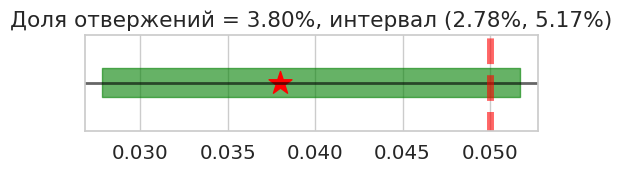

(0.038, (0.027809004509302626, 0.05172692033135032))

In [ ]:
sample_size = 1000
n_iter = 1000

run_experiments(
    test=lambda x, y: wrapper_linearization_ratio_ttest(x, y, cuped=True, eta=0.5, strat_names = ['regionCountry']),
    generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
    sample_size=sample_size,
    n_iter=n_iter,
    effect=0,
    show_pvals=False,
)

Валидация прошла успешно!

Сравни критерии по линеаризованной метрике по мощности при использовании CUPED и в простом случае.







0it [00:00, ?it/s]





1it [01:06, 66.39s/it]





2it [02:04, 61.68s/it]





3it [03:09, 62.86s/it]





4it [04:02, 59.33s/it]





5it [04:57, 57.55s/it]





6it [05:51, 56.36s/it]





7it [06:51, 58.75s/it]






0it [00:00, ?it/s]





1it [00:53, 53.79s/it]





2it [01:45, 52.43s/it]





3it [02:35, 51.57s/it]





4it [03:34, 54.28s/it]





5it [04:25, 53.21s/it]





6it [05:12, 51.21s/it]





7it [06:08, 52.66s/it]


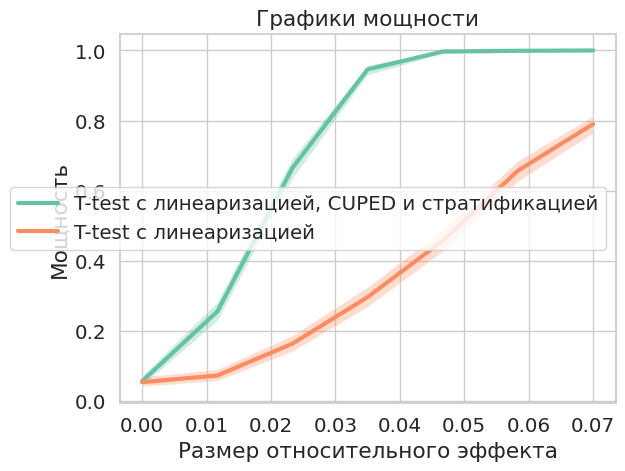

In [ ]:
n_iter = 1000
sample_size = 1000

effects_list = np.linspace(0, 0.07, 7)
powers = np.zeros(len(effects_list))
left_bounds = np.zeros(len(effects_list))
right_bounds = np.zeros(len(effects_list))

for i, effect in tqdm(enumerate(effects_list)):
    powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
        test=lambda x, y: wrapper_linearization_ratio_ttest(x, y, cuped=True, eta=0.5, strat_names = ['regionCountry', 'isNewUser', 'bounce', 'operatingSystemRoot']),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=n_iter,
        draw=False
    )

draw_power(
    powers,
    left_bounds,
    right_bounds,
    label="T-test с линеаризацией, CUPED и стратификацией",
    new_figure=False,
    effects_list=effects_list,
)

for i, effect in tqdm(enumerate(effects_list)):
    powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
        test=lambda x, y: wrapper_linearization_ratio_ttest(x, y, cuped=False, eta=0.5, strat_names = None),
        generate_sample_control=lambda size: generate_session_sample_with_prepilot(size),
        effect=effect,
        sample_size=sample_size,
        n_iter=n_iter,
        draw=False
    )

draw_power(
    powers,
    left_bounds,
    right_bounds,
    label="T-test с линеаризацией",
    new_figure=False,
    effects_list=effects_list,
)

**Вывод:**
* Линеаризация и агрегация по пользователям показали себя лучше метода бакетов - первые два метода имеют меньшую ширину полосы около 0, из-за чего меньше точек в которых есть НЕ сонаправленность
* Был реализован и успешно провалидирован критерий t-test с линеаризацией, CUPED и стратификацией, этот тест имеет мощность куда больше обычного теста с линеаризацией, из чего делаем вывод что CUPED и стратификация увеличивают мощность при линеаризации